# Project description
In the US alone, restaurants waste 25bn pounds of food every year before it reaches the consumers plate and independent restaurants are a large driver of this. In this project we have partnered with Burnt, whose mission is to help restaurants automate their back-of-house operational flow: recipe management, inventory forecasting, analysis and optimization of costs. Restaurants on average use 5-10 different suppliers with varying ways of describing their supplies. To tackle this, we will employ a large language model (LLM) and fine-tune it to process text description of the suppliers and categorize them into predefined categories. We will train our model on collected and unlabelled real-world data provided by Burnt. This will not only aid in streamlining inventory management and procurement, but will also impact management on food costs, menu item gross product, and budget forecasts.


Stakeholders
- Restaurants
- Burnt
- Investors
- Consumers

KPIs:
- Accuracy of sales forecasting

# Project Timeline

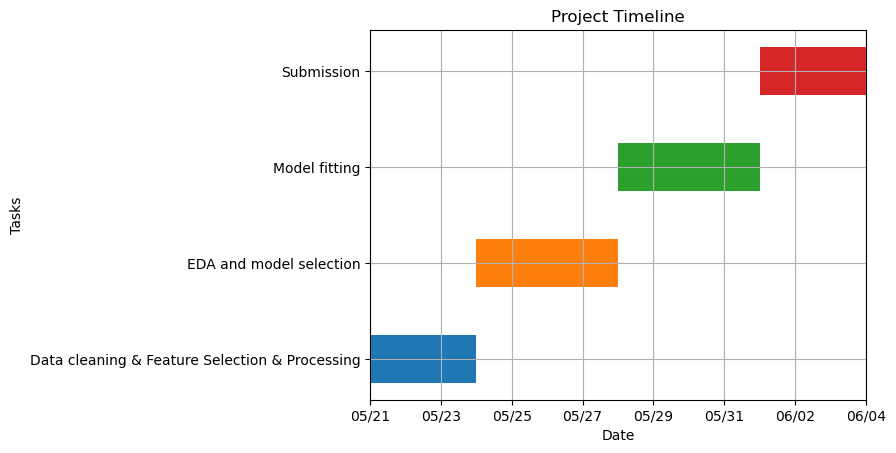

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

# Step 2: Create the data for the Gantt chart
tasks = ['Data cleaning & Feature Selection & Processing', 'EDA and model selection', 'Model fitting', 'Submission']
start_dates = ['2024-05-21', '2024-05-24', '2024-05-28', '2024-06-01']
durations = [3, 4, 4, 3]

# Step 3: Initialize the figure and axis
fig, ax = plt.subplots()

# Step 4: Set y-axis tick labels
ax.set_yticks(np.arange(len(tasks)))
ax.set_yticklabels(tasks)

# Step 5: Plot each task as a horizontal bar
for i in range(len(tasks)):
    start_date = pd.to_datetime(start_dates[i])
    end_date = start_date + pd.DateOffset(days=durations[i])
    ax.barh(i, end_date - start_date, left=start_date, height=0.5, align='center')

# Step 6: Set x-axis limits
min_date = pd.to_datetime(min(start_dates))
max_date = pd.to_datetime(max(start_dates)) + pd.DateOffset(days=min(durations))
ax.set_xlim(min_date, max_date)

# Step 7: Customize the chart
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Tasks')
ax.set_title('Project Timeline')

# Step 8: Display the chart
plt.grid(True)
plt.show()

# Data loading and pre-processing

In [16]:
df=pd.read_csv('sales-output-new-7.csv')

#First we remove spaces in the labels of columns
df.columns=df.columns.str.strip()

# We identify that some columns have missing seconds
print(df['Date'].iloc[170])
print(df['Date'].iloc[169])
print(df['Date'].iloc[183])

# use format for dates
# for the entries that fails to parse and is NaT parses them in the second format without seconds
#df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce').fillna(
#    pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M', errors='coerce'))
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce').fillna(pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M', errors='coerce')).dt.floor('h')

# We remove spaces and get all the unique categories
df['Item Name']=df['Item Name'].str.strip()
categories=df['Item Name'].unique()

# We remove 'NO make - KITCHEN') and 'No make BAR' categories
remove=['NO make - KITCHEN','NO make BAR']
categories = [item for item in categories if item not in remove]

# First we make a dictionary of dataframes per each unique category
df_dict = {category: group for category, group in df.groupby('Item Name')}

# We make an hourly dictionary
df_hourly_dict = {category: df_dict[category].groupby(df_dict[category]['Date'])[['Quantity','Price']].sum() for category in categories}
df_hourly_dict = {category: df_hourly_dict[category].reset_index() for category in categories }

print("We create a dictionary of data frames per each menu item. For example for Aperol Spritz")
print(df_hourly_dict['Aperol Spritz'].head(4))


2022-10-01T13:52:25
2022-10-01T13:52
2022-10-01T14:13
We create a dictionary of data frames per each menu item. For example for Aperol Spritz
                 Date  Quantity  Price
0 2022-10-01 14:00:00         6   71.4
1 2022-10-01 20:00:00         1   14.0
2 2022-10-01 21:00:00         2   28.0
3 2022-10-01 22:00:00         3   28.0


### Getting the weather data

In [17]:
from datetime import datetime
from meteostat import Point, Hourly
import warnings

# This function converts to datetime
def modify_index(index_value):
        return index_value.date()
# This function retrieves the weather
warnings.filterwarnings('ignore', category=FutureWarning, message=".*'H' is deprecated and will be removed in a future version, please use 'h' instead.*")

def get_weather(input_df):
    location = Point(40.7128, -74.0060)
    start_date=input_df['Date'].iloc[0]
    end_date=input_df['Date'].iloc[-1]

    start = datetime(start_date.year, start_date.month, start_date.day,start_date.hour)
    end = datetime(end_date.year, end_date.month, end_date.day,end_date.hour)

    # Get data
    data = Hourly(location, start, end)
    data = data.fetch()

    # Drop non-relevant columns
    data.drop(['wpgt','tsun','wdir','snow','pres','wspd','coco','dwpt','rhum'], axis=1, inplace=True)

    # Reset index and create a Date column
    data=data.reset_index()
    data.rename(columns={'time': 'Date'}, inplace=True)

    return data

for category in categories:
    val=get_weather(df_hourly_dict[category])
    df_hourly_dict[category]=pd.merge(df_hourly_dict[category], val, on='Date', how='left')

### Useful functions

In [18]:
import holidays

us_holidays = holidays.US()

# This function checks whether a date is weekend or not
def is_weekend(date):
    if date.weekday()==5 or date.weekday()==6:
        return True
    else:
        return False

# This function checks if it rains or not on a given day
def is_rain(prec):
    if prec==0.0:
        return False
    else:
        return True

# This function checks whether or not a day is a US holiday
def is_holiday(date_h):
    return date_h in us_holidays

# This function chekcks what week a day belong to
def check_week(date):
    ref_year=2022
    year=date.year
    return date.isocalendar()[1]+52*(year-ref_year)

In [19]:
for category in categories:
    df_hourly_dict[category]['Weekend']=1*df_hourly_dict[category]['Date'].map(is_weekend)
    df_hourly_dict[category]['Rain']=1*df_hourly_dict[category]['prcp'].map(is_rain)
    df_hourly_dict[category]['Holiday']=1*df_hourly_dict[category]['Date'].map(is_holiday)
    df_hourly_dict[category]['Week']=df_hourly_dict[category]['Date'].map(check_week)


print('The final dataframe for each menu item will look like:')
df_hourly_dict['Aperol Spritz']

The final dataframe for each menu item will look like:


,Date,Quantity,Price,temp,prcp,Weekend,Rain,Holiday,Week
0,2022-10-01 14:00:00,6,71.4,12.2,15.0,1,1,0,39
1,2022-10-01 20:00:00,1,14.0,15.2,0.0,1,0,0,39
2,2022-10-01 21:00:00,2,28.0,15.4,0.0,1,0,0,39
3,2022-10-01 22:00:00,3,28.0,15.6,0.0,1,0,0,39
4,2022-10-02 15:00:00,1,14.0,14.2,0.8,1,1,0,39
...,...,...,...,...,...,...,...,...,...
231,2023-04-01 12:00:00,1,15.0,13.3,0.0,1,0,0,65
232,2023-04-01 15:00:00,2,15.0,16.0,0.0,1,0,0,65
233,2023-04-01 16:00:00,6,82.5,16.7,0.1,1,1,0,65
234,2023-04-01 17:00:00,4,60.0,16.7,0.2,1,1,0,65


### Categorize data

In [20]:
df_drink_type=pd.read_csv('categories-unique-drink.csv')

# Retrieve a list for each drink type
Cocktails=list(df_drink_type.loc[df_drink_type['Cocktail'] == 1]['Items'].values)
Wine_and_beer=list(df_drink_type.loc[df_drink_type['Wine_and_beer'] == 1]['Items'].values)
Drinks=list(df_drink_type.loc[df_drink_type['Drink'] == 1]['Items'].values)

# Check correlation
The only factor that seems to affect price (weakly) is whether or not is a weekend 

In [23]:
categories2=[category for category in categories if len(df_hourly_dict[category])>100]

Corr_weekend={}
Corr_Rain={}
Corr_Holiday={}
Corr_temp={}

for category in categories2:
    
    coeff=df_hourly_dict[category]['Quantity'].corr(df_hourly_dict[category]['Weekend'])
    if coeff>0.3:
        Corr_weekend[category]=coeff
    coeff=df_hourly_dict[category]['Quantity'].corr(df_hourly_dict[category]['temp'])
    if coeff>0.3:
        Corr_temp[category]=coeff
    coeff=df_hourly_dict[category]['Quantity'].corr(df_hourly_dict[category]['Rain'])
    if coeff>0.3:
        Corr_Rain[category]=coeff
    coeff=df_hourly_dict[category]['Quantity'].corr(df_hourly_dict[category]['Holiday'])
    if coeff>0.3:
        Corr_Holiday[category]=coeff

print("Rain correalation")
print(Corr_Rain)
print("Temperature correalation")
print(Corr_temp)
print("Holiday correlation")
print(Corr_Holiday)
print("Weekend correlation")
print(Corr_weekend)



Rain correalation
{}
Temperature correalation
{}
Holiday correlation
{}
Weekend correlation
{'Omelette': 0.31749879222681393, 'Lemon Ricotta Pancakes': 0.3612820900286801, 'Cappuccino': 0.3198861264048655, 'Zucchini Fritters': 0.3450987513082055, 'Coffee Americano': 0.37720514787647696, 'Poached Eggs & Polenta': 0.3530956109273018}


# Total items Analysis

     Week       Day  Quantity
2       1  Saturday       548
9       2  Saturday       606
16      3  Saturday       705
23      4  Saturday       688
30      5  Saturday       641
37      6  Saturday       751
44      7  Saturday       570
51      8  Saturday       657
58      9  Saturday       682
65     10  Saturday       630
72     11  Saturday       746
79     12  Saturday       617
86     13  Saturday       712
90     39  Saturday       659
94     40  Saturday       931
101    41  Saturday       813
108    42  Saturday       882
115    43  Saturday       701
122    44  Saturday       730
129    45  Saturday       935
136    46  Saturday       766
143    47  Saturday       322
149    48  Saturday       732
156    49  Saturday       909
163    50  Saturday       811
173    51   Tuesday       346
175    52    Friday       417


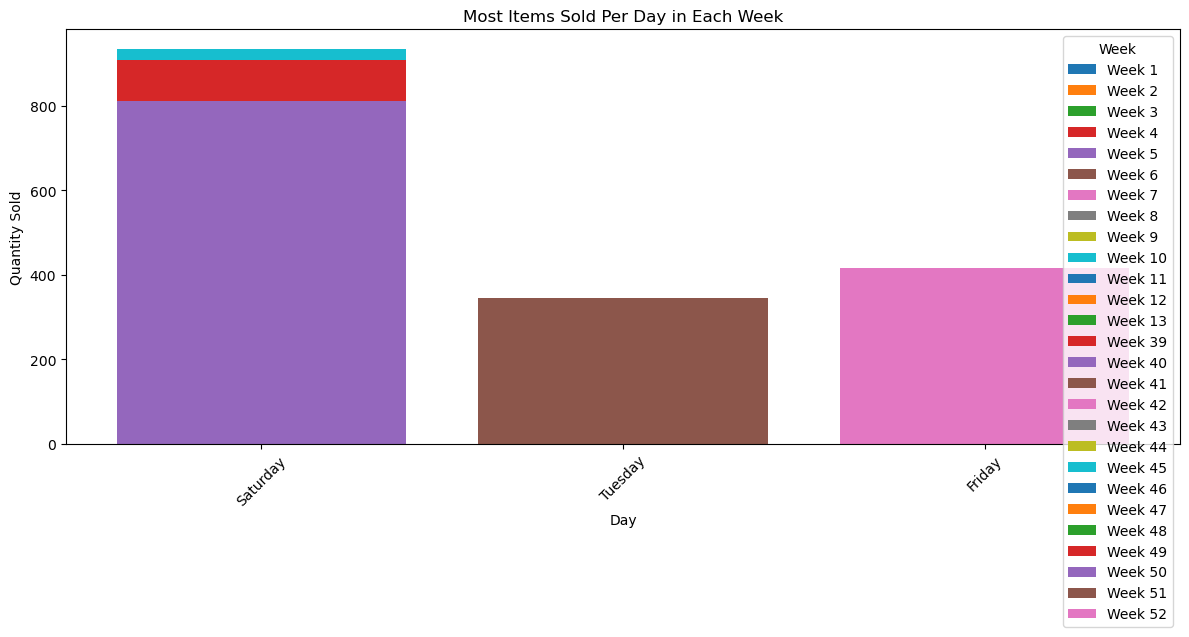

In [8]:
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day_name()

weekly_sales = df.groupby(['Week', 'Day']).agg({'Quantity': 'sum'}).reset_index()

most_items_sold_per_week = weekly_sales.loc[weekly_sales.groupby('Week')['Quantity'].idxmax()]

print(most_items_sold_per_week)

fig, ax = plt.subplots(figsize=(12, 6))
for week in most_items_sold_per_week['Week'].unique():
    week_data = most_items_sold_per_week[most_items_sold_per_week['Week'] == week]
    ax.bar(week_data['Day'], week_data['Quantity'], label=f'Week {week}')
ax.set_title('Most Items Sold Per Day in Each Week')
ax.set_xlabel('Day')
ax.set_ylabel('Quantity Sold')
ax.legend(title='Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
daily_quantity = df.resample('D', on='Date')['Quantity'].sum().reset_index()
daily_quantity


,Date,Quantity
0,2022-10-01,659
1,2022-10-02,305
2,2022-10-03,204
3,2022-10-04,269
4,2022-10-05,302
...,...,...
178,2023-03-28,196
179,2023-03-29,229
180,2023-03-30,192
181,2023-03-31,459


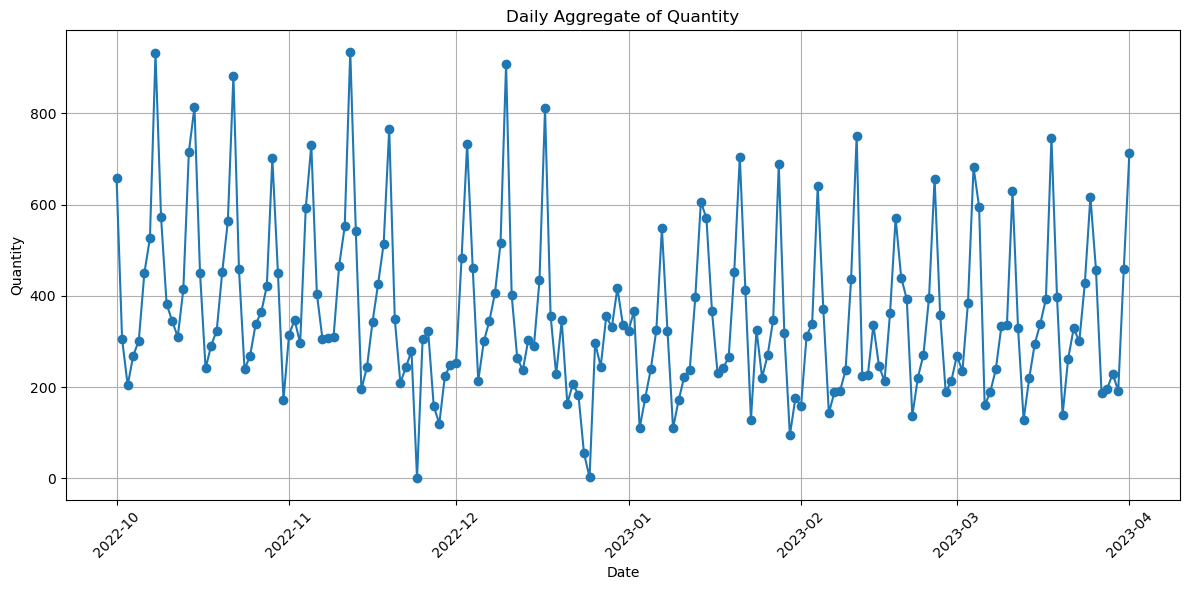

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(daily_quantity['Date'], daily_quantity['Quantity'], marker='o')
plt.title('Daily Aggregate of Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

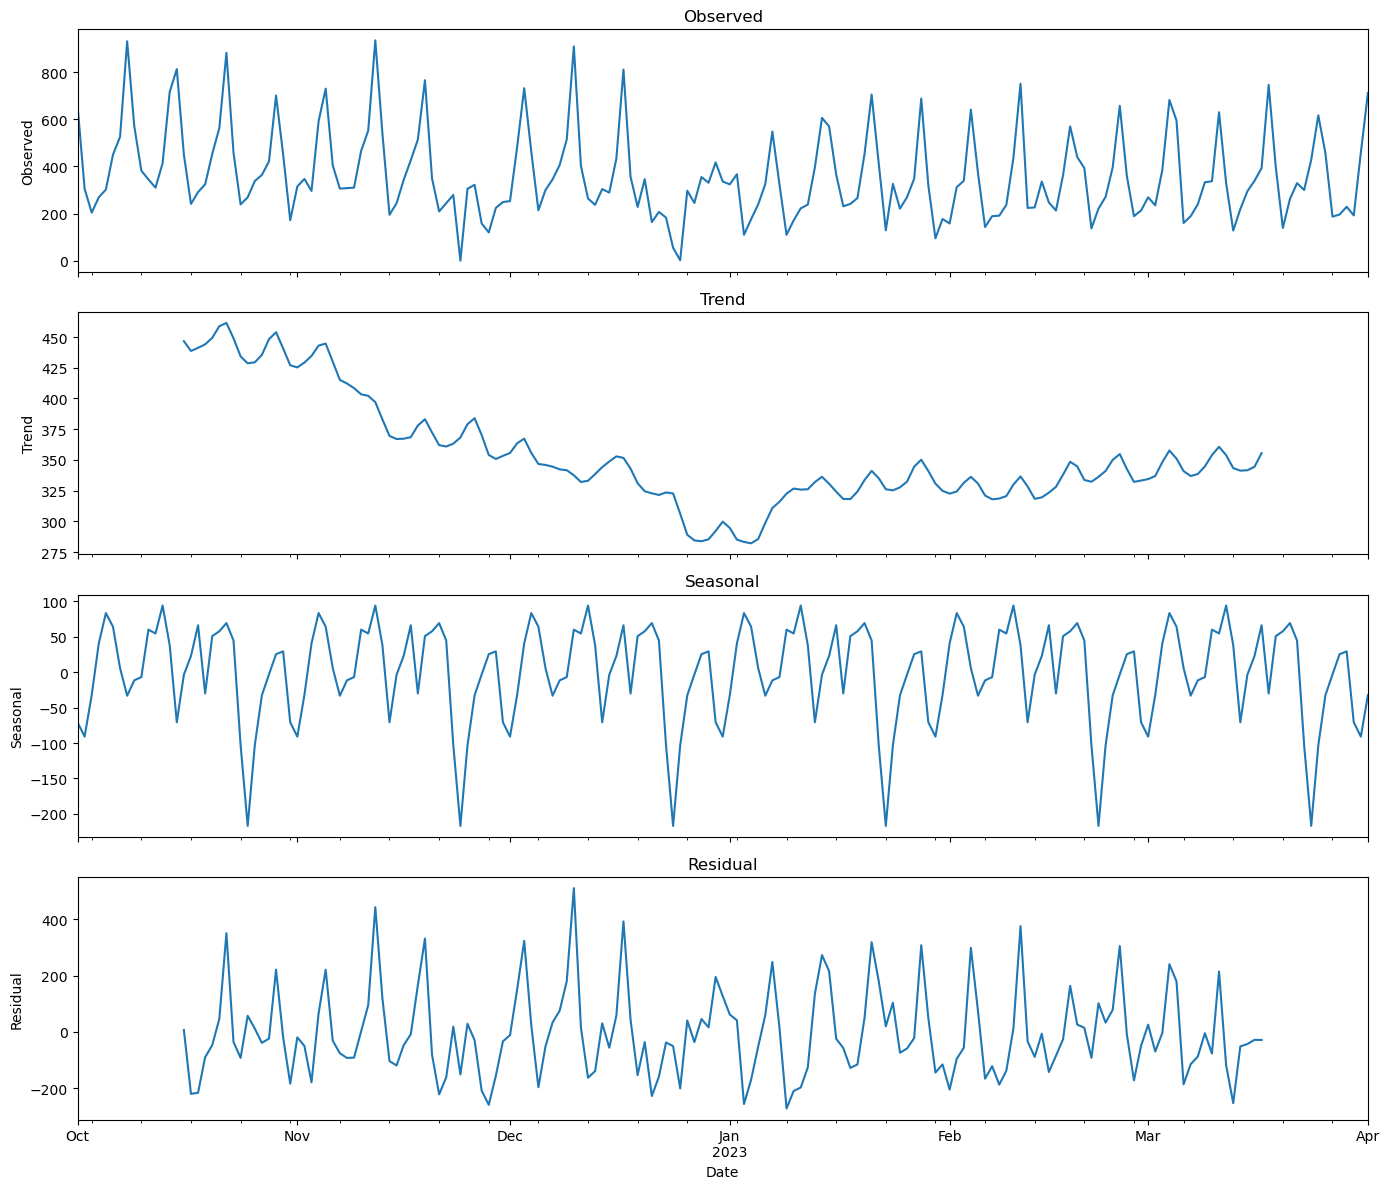

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

daily_quantity.set_index('Date', inplace=True)

decomposition = seasonal_decompose(daily_quantity['Quantity'], model='additive', period=30)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

decomposition.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observed')
ax1.set_title('Observed')

decomposition.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
ax2.set_title('Trend')

decomposition.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal')

decomposition.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')
ax4.set_title('Residual')

plt.tight_layout()
plt.show()

In [12]:
daily_quantity

,Quantity
Date,
2022-10-01,659
2022-10-02,305
2022-10-03,204
2022-10-04,269
2022-10-05,302
...,...
2023-03-28,196
2023-03-29,229
2023-03-30,192


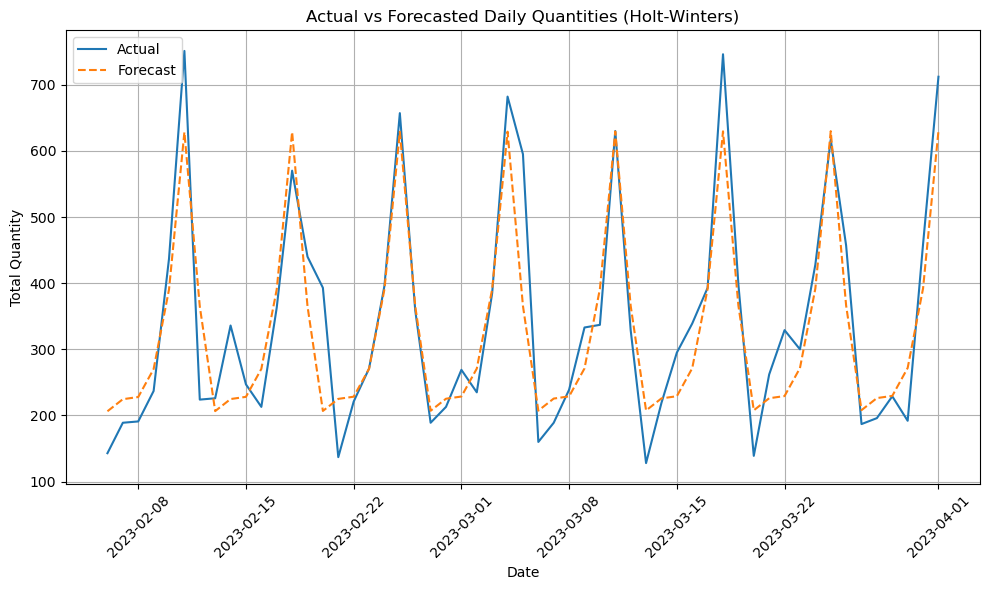

Holt-Winters MAE: 51.54275258594079, RMSE: 68.80021606009338


In [13]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

daily_quantity.reset_index(inplace=True)
daily_quantity.columns = ['Date', 'Total Quantity']

daily_quantity['Date'] = pd.to_datetime(daily_quantity['Date'])

train_size = int(len(daily_quantity) * 0.7)
train, test = daily_quantity['Total Quantity'][:train_size], daily_quantity['Total Quantity'][train_size:]

holt_winters_model = ExponentialSmoothing(train, seasonal='add', trend='add', seasonal_periods=7).fit()

holt_winters_forecast = holt_winters_model.forecast(steps=len(test))

holt_winters_forecast_df = pd.DataFrame({'Actual': test.values, 'Forecast': holt_winters_forecast})

plt.figure(figsize=(10, 6))
plt.plot(daily_quantity['Date'][-len(test):], test, label='Actual')
plt.plot(daily_quantity['Date'][-len(test):], holt_winters_forecast, label='Forecast', linestyle='--')
plt.title('Actual vs Forecasted Daily Quantities (Holt-Winters)')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

holt_winters_mae = mean_absolute_error(test, holt_winters_forecast)
holt_winters_mse = mean_squared_error(test, holt_winters_forecast)
holt_winters_rmse = holt_winters_mse ** 0.5
print(f"Holt-Winters MAE: {holt_winters_mae}, RMSE: {holt_winters_rmse}")


# Itemized Analysis

### Identifying stationarity on Data

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, significance_level=0.05):
    # This returns a list with adf statistic (float), p-value (float), usedlag(int), nobs(int), critical values (dict),icbest(fl
    result = adfuller(series)
    # We take the p value
    p_value = result[1]
    # Returns true for stationary data
    return p_value < significance_level

# This function will differentiate the data until it is stationary (if the number of dif is smaller than 3)
def check_d_arima(series):
    n_dif=0
    stationarity = adf_test(series)
    while stationarity == False and n_dif<3:
        series_diff=series.diff().dropna()
        stationarity=adf_test(series_diff)
        n_dif=n_dif+1
    return n_dif

# Create a dictionary of itmes wih d paramter ARIMA(p,d,q) if the item has at least 100 data points
d={}
for category in categories:
    if len(df_hourly_dict[category]) > 100:
        n=check_d_arima(df_hourly_dict[category]['Quantity'])
        d[category]=n

In [15]:
d['Lentils soup']

1

### Plots on stationarity

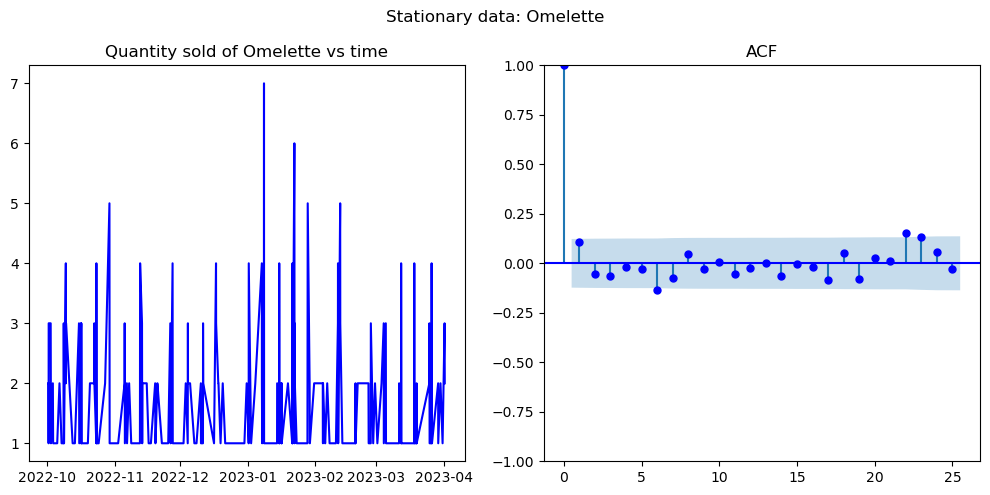

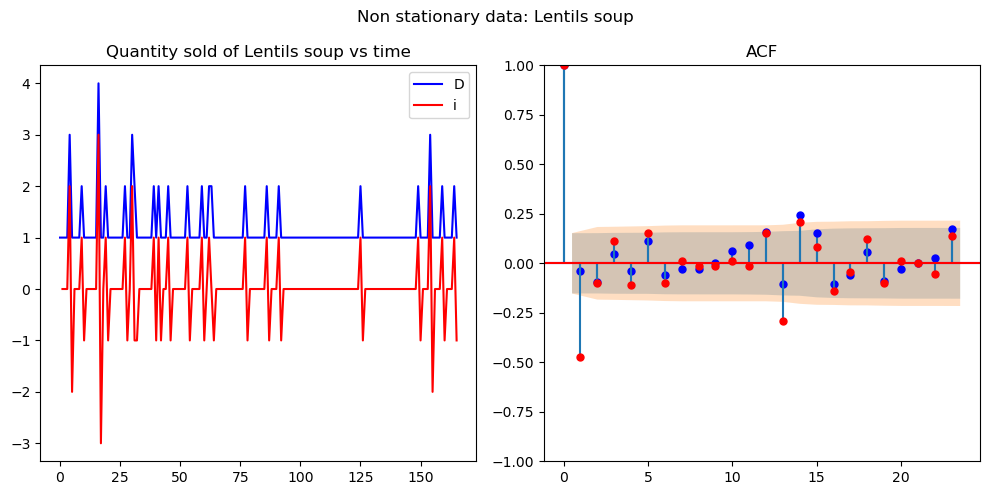

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

# For example Tiramisu is non-stationary (needs one diff) and omelette is stationary

name='Omelette'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(df_hourly_dict[name]['Date'], df_hourly_dict[name]['Quantity'], color='blue')
axs[0].set_title(f'Quantity sold of {name} vs time')

# Plotting data on the second subplot
plot_acf(df_hourly_dict[name]['Quantity'], ax=axs[1],color='blue')
axs[1].set_title('ACF')

plt.suptitle(f'Stationary data: {name}')
plt.tight_layout()
plt.show()

name='Lentils soup'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.title('Omelette')
axs[0].plot(df_hourly_dict[name]['Quantity'], color='blue')
axs[0].legend('Data')
axs[0].plot(df_hourly_dict[name]['Quantity'].diff().dropna(), color='red')
axs[0].legend('Differentiated Data')
axs[0].set_title(f'Quantity sold of {name} vs time')

# Plotting data on the second subplot
plot_acf(df_hourly_dict[name]['Quantity'], ax=axs[1],color='blue')
plot_acf(df_hourly_dict[name]['Quantity'].diff().dropna(), ax=axs[1],color='red')
axs[1].set_title('ACF')

plt.suptitle(f'Non stationary data: {name}')
plt.tight_layout()
plt.show()

### ARIMA(X) tests

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import ARIMA

def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

# Selecting some items to try the model
probar=['Omelette','Aperol Spritz','Latte','Panna Cotta','Coke']

for probar in probar:

    item_name=probar

    # last week worth of data aside for testing
    value=len(df_hourly_dict[item_name][df_hourly_dict[item_name]['Week']==df_hourly_dict[item_name]['Week'].values[-1]])
    
    print('Number of test points:', value)

    df_train = df_hourly_dict[item_name].iloc[:-value].copy()
    df_test = df_hourly_dict[item_name].drop(df_train.index).copy()

    cv=TimeSeriesSplit(n_splits=10,test_size=10)

    arima_mase=np.zeros((10,4,4))

    i=0
    for train_index, test_index in cv.split(df_train):
        df_tt=df_train.iloc[train_index]
        df_ho=df_train.iloc[test_index]

        j = 0
        for p in range(4):
            k = 0
            for q in range(4):
                #arima = ARIMA(df_tt['Quantity'].values,
                #                  order=(p, d['Aperol Spritz'], q)).fit()
                model=ARIMA(df_tt['Quantity'].values,
                                order=(p, d[item_name], q))
                #arima=model.fit(method='innovations_mle')
                arima=model.fit(method='innovations_mle')
                arima_mase[i,j,k] = mase(df_tt['Quantity'].values, df_ho['Quantity'].values,  arima.forecast(len(df_ho)))
                k = k +1
            j = j + 1
        i = i +1

    arima_ind = np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None),
                                np.mean(arima_mase, axis=0).shape)
    np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None),
                    np.mean(arima_mase, axis=0).shape)

    print("best ARIMA model",
            "(p,d,q) = ( %s, %s, %s )" %(range(4)[arima_ind[0]], 1, range(4)[arima_ind[1]]))

    print("Average cv mase of",
            np.round(np.mean(arima_mase, axis=0)[arima_ind],3))


    model=ARIMA(df_hourly_dict[item_name]['Quantity'],order=(range(4)[arima_ind[0]], 1, range(4)[arima_ind[1]])).fit()

    steps=value
    forecast = model.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()
    forecast_index = np.arange(len(df_train), len(df_train) + steps)

    mean=[df_test['Quantity'].mean() for i in df_test.index]
    pred_mean=[forecast_values.mean() for i in df_test.index]

    print(f'Predicted weekly sales of {item_name} = ', mean[0])
    print(f'Actual weekly sales of {item_name} = ', pred_mean[0])
    print('Relative errror (%)',np.abs(mean[0]-pred_mean[0])/mean[0]*100)
    print("--------------------------------------------------------------")

Number of test points: 6
best ARIMA model (p,d,q) = ( 2, 1, 3 )
Average cv mase of 0.84
Predicted weekly sales of Omelette =  1.8333333333333333
Actual weekly sales of Omelette =  1.7282117602988751
Relative errror (%) 5.733903983697716
--------------------------------------------------------------
Number of test points: 10


best ARIMA model (p,d,q) = ( 2, 1, 2 )
Average cv mase of 0.876
Predicted weekly sales of Aperol Spritz =  2.1
Actual weekly sales of Aperol Spritz =  1.926517937137629
Relative errror (%) 8.261050612493857
--------------------------------------------------------------
Number of test points: 8
best ARIMA model (p,d,q) = ( 3, 1, 1 )
Average cv mase of 0.856
Predicted weekly sales of Latte =  1.625
Actual weekly sales of Latte =  1.8902587117343095
Relative errror (%) 16.32361302980366
--------------------------------------------------------------
Number of test points: 5
best ARIMA model (p,d,q) = ( 2, 1, 3 )
Average cv mase of 0.907
Predicted weekly sales of Panna Cotta =  1.0
Actual weekly sales of Panna Cotta =  1.1671035868858233
Relative errror (%) 16.71035868858233
--------------------------------------------------------------
Number of test points: 7
best ARIMA model (p,d,q) = ( 2, 1, 3 )
Average cv mase of 0.976
Predicted weekly sales of Coke =  1.2857142857142858
Actual weekly 